In [1]:
import os
from IPython.display import Image as ipy_image
from IPython.display import display

#from utils.demo_util import get_shape_comp_model, get_shape_comp_opt, make_dummy_batch
#from utils.qual_util import load_bert2vqsc_model, get_lang_prob, save_mesh_as_gif
from utils.qual_util import get_lang_prob, save_mesh_as_gif
from utils.util import seed_everything
from utils.util_3d import init_mesh_renderer, sdf_to_mesh
import os
from termcolor import colored, cprint
import torch
import utils.util as util
from tqdm.notebook import tqdm

from datasets.ys_shapeset import  ShapeNetZSets

from datasets.text2shape import  Text2Shape





import cv2
import numpy as np
import imageio
from PIL import Image
from einops import rearrange
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as transforms

from pytorch3d import structures

from utils.util_3d import sdf_to_mesh, render_mesh, rotate_mesh_360


from datasets.text2shape import  Text2Shape


%reload_ext autoreload
%autoreload 2

In [4]:
seed_everything(111)

description = "transformer sanity check"
res_dir = 'logs/transformer-sanity-v1'
if not os.path.exists(res_dir): os.makedirs(res_dir)

with open(f"{res_dir}/description.txt","w") as f:
    f.write(description)

gpu_id = 0
nimgs=6

class Opt:
    def __init__(self):
        self.name = 'opt'

In [5]:
def create_model(opt):
    model = None

    if opt.model == 'pvqvae':
        # vqvae
        from models.pvqvae_model import PVQVAEModel
        model = PVQVAEModel()
    elif opt.model == 'rand_tf':
        # transformer
        from models.rand_tf_model import RandTransformerModel
        model = RandTransformerModel()
    elif opt.model == 'rand_tf_old':
        from models.rand_tf_model_old import RandTransformerModelOld
        model = RandTransformerModelOld()
    elif opt.model == 'seq_tf':
        # seq-transformer
        from models.seq_tf_model import SeqTransformerModel
        model = SeqTransformerModel()
    elif opt.model == 'bert2vq':
        from models.bert2vq_model import BERT2VQModel
        model = BERT2VQModel()
    elif opt.model == "bert2vqsc":
        from models.bert2vq_scmodel import BERT2VQSCModel
        model = BERT2VQSCModel()
    elif opt.model == 'resnet2vq':
        from models.resnet2vq_model import ResNet2VQModel
        model = ResNet2VQModel()
    elif opt.model == 'resnet2vox':
        from models.resnet2vox_model import ResNet2VoxModel
        model = ResNet2VoxModel()
    elif opt.model == 'resnet2sdf':
        from models.resnet2sdf_model import ResNet2SDFModel
        model = ResNet2SDFModel()
    elif opt.model == 'baseline_je':
        from models.baseline_je_model import LangJEModel
        model = LangJEModel()
    elif opt.model == 'img_je':
        from models.img_je_model import ImgJEModel
        model = ImgJEModel()
    else:
        raise ValueError("Model [%s] not recognized." % opt.model)

    model.initialize(opt)
    cprint("[*] Model has been created: %s" % model.name(), 'blue')
    if(opt.ckpt is not None):
        model.load_ckpt(opt.ckpt)
        print("MODEL LOADED")
    return model

In [6]:
class Opt():
    print("class")
    
def get_shape_comp_opt(gpu_id=0):
    opt = Opt()

    # args
    gpuid=[gpu_id]
    batch_size=16
    max_dataset_size=64

    name='new_bert_overfit'

    # default args
    opt.serial_batches = False
    opt.nThreads = 4

    # important args
    opt.dataset_mode = 'shapenet_code'
    opt.bert_cfg = "./configs/bert2vqsc.yaml"
    opt.seed = 111
    opt.isTrain = True
    opt.gpu_ids = gpuid
    opt.max_dataset_size=64
    opt.device = 'cuda:%s' % gpuid[0]
    opt.batch_size = batch_size
    opt.max_dataset_size = max_dataset_size
    opt.logs_dir="logs"
    opt.name = name
    opt.lr = 1e-4
    opt.save_latest_freq = 1000
    opt.print_freq = 1
    #utils.util.seed_everything(opt.seed)
    opt.phase = 'test'
    opt.nepochs = 100
    opt.nepochs_decay = 60
    opt.mlp_layers = 3
    opt.mlp_hidden = 1024
    return opt
opt = get_shape_comp_opt()


def get_shape_comp_model(opt, model, ckpt):
    
    # load tf stuff
    opt.model=model
    opt.tf_cfg='configs/rand_tf_snet_code.yaml'
    opt.ckpt = ckpt
    
    # load vq stuff
    opt.vq_model='pvqvae'
    opt.vq_cfg='configs/pvqvae_snet.yaml'
    opt.vq_ckpt='../raw_dataset/checkpoints/vqvae.pth'
    
    ### opt.vq_dset='sdf_code' # original
    opt.vq_dset='snet'

    model = create_model(opt)
    print(f'[*] "{opt.model}" initialized.')
    model.load_ckpt(opt.ckpt)
        
    return model

class


In [10]:
dataset = Text2Shape()
#opt = Opt()

dataset.initialize(opt,isTrain=False)
len(dataset)

64

In [7]:
opt = get_shape_comp_opt(gpu_id=gpu_id)
opt.dataset_mode = "text2shape"

#new_checkpoint_path = "logs/valid-valid-with-fusion-rand_tf-owndataset-chair-LR1e-4-clean-with-ckpt/ckpt/rand_tf_epoch-latest.pth"
new_checkpoint_path_V1 = "../raw_dataset/checkpoints_new/rand_tf_epoch_latest_fusion_transfer_v1.pth"
new_checkpoint_path_V2="../raw_dataset/checkpoints_new/rand_tf_epoch_latest_fusion_v2.pth"
new_checkpoint_path_V3 = "../raw_dataset/checkpoints_new/rand_tf_epoch_0_fusion_v3.pth"
new_checkpoint_path_V5 = "../raw_dataset/checkpoints_new/rand_tf_epoch-latest_v5.pth"


# modelV0 = get_shape_comp_model(opt,"rand_tf_old","../raw_dataset/checkpoints/rand_tf_singles_best.pth")    
# modelV0.eval()

# modelV4 =  get_shape_comp_model(opt,"rand_tf_old","../raw_dataset/checkpoints_new/rand_tf_250_epochs_v4.pth")
# modelV4.eval()

modelV1 = get_shape_comp_model(opt,"rand_tf",new_checkpoint_path_V1) 
modelV1.eval()

# modelV2 = get_shape_comp_model(opt,"rand_tf",new_checkpoint_path_V2)
# modelV2.eval()

# modelV3 = get_shape_comp_model(opt,"rand_tf",new_checkpoint_path_V3)
# modelV3.eval()

modelV5 = get_shape_comp_model(opt,"rand_tf",new_checkpoint_path_V5)
modelV5.eval()

[*] Enc has Attn at i_level, i_block: 3, 0
Working with z of shape (1, 256, 8, 8, 8) = 131072 dimensions.
[*] Dec has Attn at i_level, i_block: 3, 0
[*] VQVAE: weight successfully load from: ../raw_dataset/checkpoints/vqvae.pth
---------- Networks initialized -------------
-----------------------------------------------
[*] Model has been created: Rand-Transformer-Model


/rhome/streakfull/.cache/pypoetry/virtualenvs/adl4cv-I-Koul65-py3.8/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[*] weight successfully load from: ../raw_dataset/checkpoints_new/rand_tf_epoch_latest_fusion_transfer_v1.pth
MODEL LOADED
[*] "rand_tf" initialized.
[*] weight successfully load from: ../raw_dataset/checkpoints_new/rand_tf_epoch_latest_fusion_transfer_v1.pth
[*] Enc has Attn at i_level, i_block: 3, 0
Working with z of shape (1, 256, 8, 8, 8) = 131072 dimensions.
[*] Dec has Attn at i_level, i_block: 3, 0
[*] VQVAE: weight successfully load from: ../raw_dataset/checkpoints/vqvae.pth
---------- Networks initialized -------------
-----------------------------------------------
[*] Model has been created: Rand-Transformer-Model
[*] weight successfully load from: ../raw_dataset/checkpoints_new/rand_tf_epoch-latest_v5.pth
MODEL LOADED
[*] "rand_tf" initialized.
[*] weight successfully load from: ../raw_dataset/checkpoints_new/rand_tf_epoch-latest_v5.pth


In [8]:
dist, elev, azim = 1.7, 20, 20
mesh_renderer = init_mesh_renderer(image_size=256, dist=dist, elev=elev, azim=azim, device=opt.device)

  0%|                                                                          | 0/64 [00:00<?, ?it/s]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity-v1/0-modelV5.gif


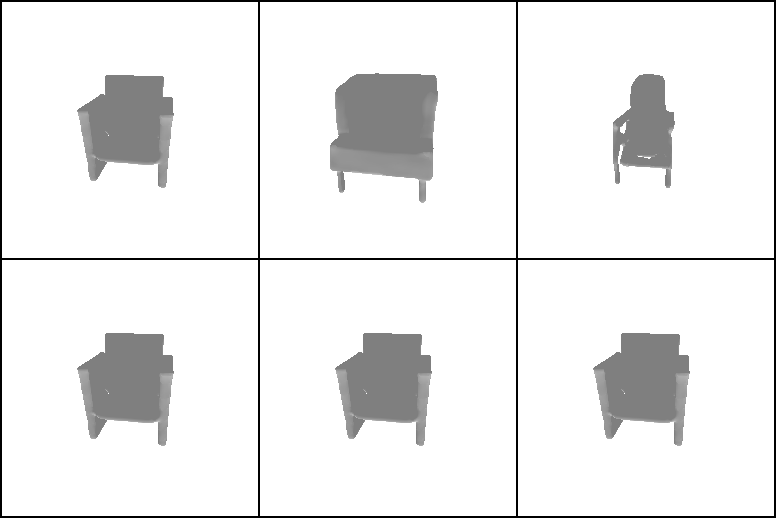

  2%|█                                                                 | 1/64 [00:07<08:14,  7.85s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity-v1/1-modelV5.gif


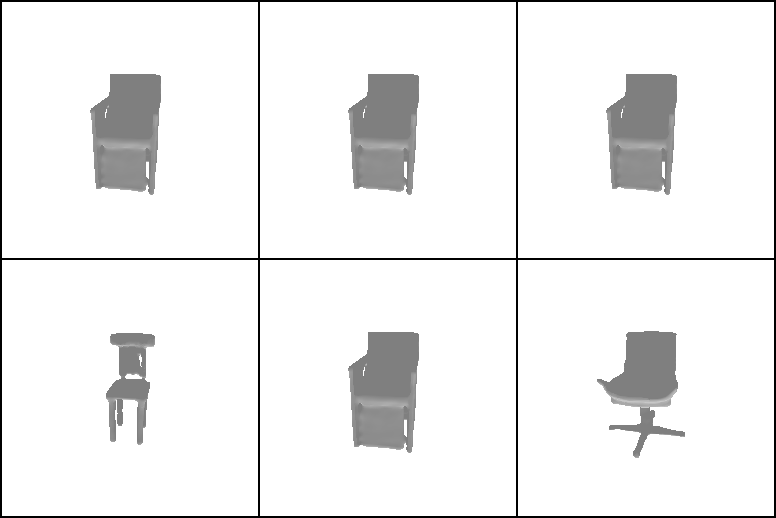

  3%|██                                                                | 2/64 [00:14<07:39,  7.41s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity-v1/2-modelV5.gif


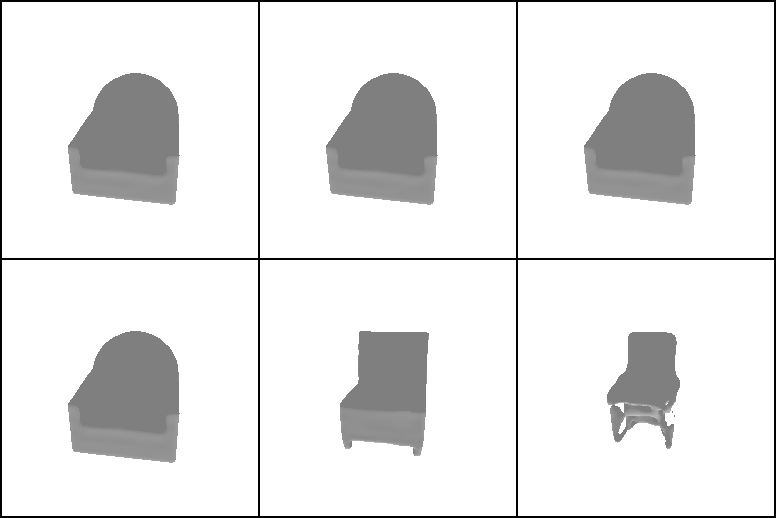

  5%|███                                                               | 3/64 [00:22<07:23,  7.27s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity-v1/3-modelV5.gif


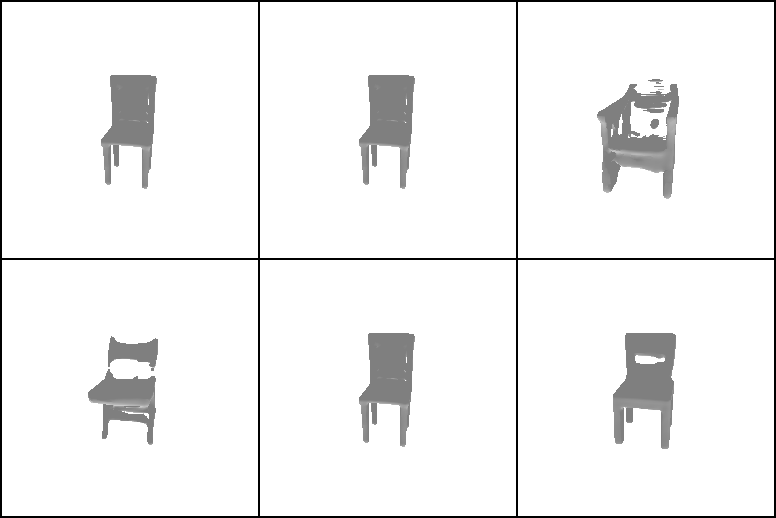

  6%|████▏                                                             | 4/64 [00:29<07:11,  7.18s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity-v1/4-modelV5.gif


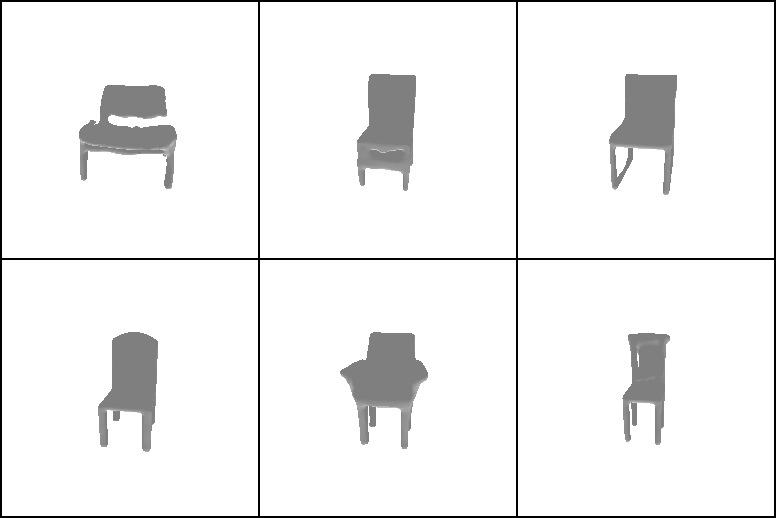

  8%|█████▏                                                            | 5/64 [00:36<07:01,  7.14s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity-v1/5-modelV5.gif


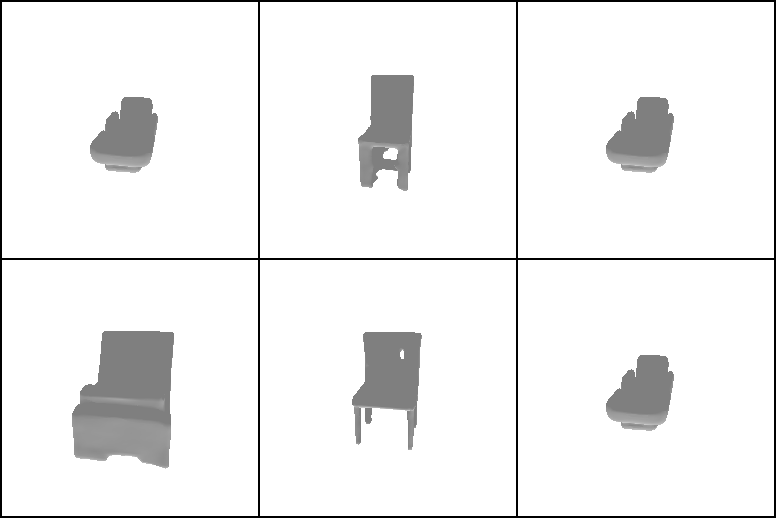

  9%|██████▏                                                           | 6/64 [00:43<06:52,  7.11s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

In [ ]:
import torch
from utils.qual_util import get_lang_prob_recursive, save_mesh_as_pics
from einops import rearrange


gpu_id = 0
#nimgs=3

class Opt:
    def __init__(self):
        self.name = 'opt'


model = modelV5
model_name = "modelV5"
#bert2vq = bert2vqV3



nimgs=6
for j in tqdm(range(len(dataset))):
    data = dataset[j]
    #import pdb;pdb.set_trace()
    z1 = data["z_set_target"].unsqueeze(0).cuda()
    test_data = { }
    sampler = torch.distributions.categorical.Categorical(z1)
    codeix = sampler.sample()
    z1  = z1.repeat_interleave(nimgs, dim=0)
    test_data["z_set"] = z1
        #test_data["z_set"] = shapeset[4]["z_set"].unsqueeze(0).repeat_interleave(nimgs, dim=0)
    test_data["idx"] = sampler.sample().repeat_interleave(nimgs, axis=0).cpu()
    model.inference(test_data, topk=30, prob=None, gen_order=None)
    gen_mesh = sdf_to_mesh(model.x_recon_tf)
    gen_gif_name = f'{res_dir}/{j}-{model_name}.gif'
    try:
        save_mesh_as_pics(mesh_renderer, gen_mesh, nrow=3, out_name=gen_gif_name)
        print("Saved:", gen_gif_name)
    except:
        import pdb;pdb.set_trace()
           
    for name in [gen_gif_name]:
        display(ipy_image(name))